# LightGBM

In [112]:
# pip install xgboost

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import lightgbm as lgb
import xgboost as xgb
from hyperopt import fmin, tpe, hp, partial, Trials, space_eval, STATUS_OK
from sklearn.preprocessing import LabelEncoder
import gc

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from functools import partial
from pprint import pprint
import numpy as np
from hyperopt.pyll import scope, stochastic
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.utils import check_random_state

In [2]:
# cat boost encoder
import category_encoders as ce

data = pd.read_csv('data_clear.csv', index_col=0)

train = data[~data['label'].isnull()]
temp_x = train.drop(columns=['user', 'label'], axis=1)
temp_y = train.loc[:, 'label']

cat_features = temp_x.select_dtypes('object').columns

catbst_enc = ce.CatBoostEncoder(cols=cat_features)
catbst_enc.fit(temp_x[cat_features], temp_y)

data[cat_features] = catbst_enc.transform(data[cat_features])

train = data[~data['label'].isnull()]
X = train.drop(columns=['user', 'label'], axis=1)
y = train.loc[:, 'label']

In [3]:
data.head()

,user,label,login_cnt_period1_x,province_x,city_x,sex_sex_x,sex_provider_x,sex_level_x,sex_verified_x,sex_regist_type_x,...,city_op2_cnt_mean,city_service1_cnt_mean,city_service1_amt_mean,city_agreement_total_mean,city_login_cnt_avg_mean,city_balance_avg_mean,city_balance2_mean,city_product1_amount_mean,city_product3_amount_mean,city_product7_cnt_mean
0,Train_00000,0.0,0.002782,17,45,0.265271,0.264166,0.294285,0.258698,0.283145,...,0.023251,0.000873,0.000930,0.329782,0.024373,0.456977,0.394828,0.091954,0.086207,0.050836
1,Train_00001,1.0,0.006121,12,204,0.265271,0.264166,0.257669,0.258698,0.283145,...,0.022878,0.000984,0.000758,0.316146,0.023442,0.435602,0.382383,0.064767,0.016839,0.060533
2,Train_00002,0.0,0.015597,5,331,0.265271,0.264166,0.257669,0.258698,0.214941,...,0.023444,0.002224,0.001742,0.363854,0.020695,0.455987,0.341534,0.095847,0.102236,0.055430
3,Train_00005,0.0,0.011220,21,326,0.265271,0.264166,0.257669,0.258698,0.283145,...,0.023927,0.003038,0.002174,0.337236,0.025890,0.474667,0.403333,0.066667,0.026667,0.056911
4,Train_00006,0.0,0.087933,13,106,0.265271,0.264166,0.257669,0.258698,0.214941,...,0.024291,0.004410,0.006652,0.354192,0.020660,0.527459,0.434631,0.081967,0.024590,0.057943


In [ ]:
seed=623

In [6]:
# prepare the test set for the final evaluation

# test_X = data[data['label'].isnull()]
# test_y = pd.read_csv('test_label_new.csv', index_col=0)
# test = pd.merge(test_X, test_y, on='user')
# test.shape

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=623)
train_data = lgb.Dataset(data=x_train,label=y_train)
test_data = lgb.Dataset(data=x_test,label=y_test)

In [12]:
df_train = train
df_test = data[data.label.isnull()].copy()

In [172]:
# # optimal parameters
# {'feature_fraction': 0.59, 
#  'learning_rate': 0.08748742858194956, 
#  'max_depth': 14, 
#  'num_leaves': 25, 
#  'reg_alpha': 10, 
#  'reg_lambda': 13, 
#  'sub_sample': 0.56}

In [13]:
ycol = 'label'
feature_names = list(filter(lambda x: x not in [ycol, 'user'], df_train.columns))

model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt',
                           num_leaves=25,
                           max_depth=14,
                           learning_rate=0.01,
                           n_estimators=10000,
                           subsample=0.56,
                           feature_fraction=0.59,
                           reg_alpha=10,
                           reg_lambda=13,
                           random_state=seed,
                           is_unbalance=True,
                           metric='auc')

df_oof = df_train[['user', ycol]].copy()
df_oof['prob'] = 0
prediction = df_test[['user']]
prediction['prob'] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(
        fold_id + 1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(X_val, num_iteration=lgb_model.best_iteration_)[:, 1]
    df_oof.loc[val_idx, 'prob'] = pred_val

    pred_test = lgb_model.predict_proba(df_test[feature_names], num_iteration=lgb_model.best_iteration_)[:, 1]
    prediction['prob'] += pred_test / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()

<ipython-input-13-656aac5b4e82>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_1 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.784953	valid's auc: 0.755265
[200]	train's auc: 0.810053	valid's auc: 0.773166
[300]	train's auc: 0.830255	valid's auc: 0.786645
[400]	train's auc: 0.844859	valid's auc: 0.795561
[500]	train's auc: 0.856275	valid's auc: 0.801342
[600]	train's auc: 0.865435	valid's auc: 0.805698
[700]	train's auc: 0.873428	valid's auc: 0.808341
[800]	train's auc: 0.880828	valid's auc: 0.810646
[900]	train's auc: 0.887388	valid's auc: 0.812197
[1000]	train's auc: 0.89334	valid's auc: 0.813598
[1100]	train's auc: 0.898841	valid's auc: 0.814742
[1200]	train's auc: 0.903971	valid's auc: 0.815383
[1300]	train's auc: 0.908722	valid's auc: 0.815995
[1400]	train's auc: 0.913171	valid's auc: 0.816576
[1500]	train's auc: 0.917381	valid's auc: 0.816972
[1600]	

<ipython-input-13-656aac5b4e82>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_2 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.784186	valid's auc: 0.744694
[200]	train's auc: 0.811057	valid's auc: 0.764014
[300]	train's auc: 0.830426	valid's auc: 0.778513
[400]	train's auc: 0.844681	valid's auc: 0.788796
[500]	train's auc: 0.855844	valid's auc: 0.795586
[600]	train's auc: 0.865102	valid's auc: 0.800713
[700]	train's auc: 0.873033	valid's auc: 0.804245
[800]	train's auc: 0.880382	valid's auc: 0.807075
[900]	train's auc: 0.886579	valid's auc: 0.809045
[1000]	train's auc: 0.892494	valid's auc: 0.810517
[1100]	train's auc: 0.897774	valid's auc: 0.811591
[1200]	train's auc: 0.902685	valid's auc: 0.812234
[1300]	train's auc: 0.907299	valid's auc: 0.812777
[1400]	train's auc: 0.911615	valid's auc: 0.813227
[1500]	train's auc: 0.915776	valid's auc: 0.813497
[1600]

In [14]:
pred_lgb = prediction
prediction.head()

,user,prob
38225,Train_08221,0.690334
38226,Train_23216,0.767682
38227,Train_29740,0.077935
38228,Train_11378,0.520447
38229,Train_09309,0.499871


In [15]:
test_y = pd.read_csv('test_label_new.csv', index_col=0)
test_y.head()

,user,label
0,Train_08043,1
1,Train_28969,0
2,Train_09002,1
3,Train_05608,1
4,Train_25993,0


In [16]:
test = pd.merge(test_y,prediction, on='user')
test.head()

,user,label,prob
0,Train_08043,1,0.339067
1,Train_28969,0,0.006451
2,Train_09002,1,0.396837
3,Train_05608,1,0.569167
4,Train_25993,0,0.584205


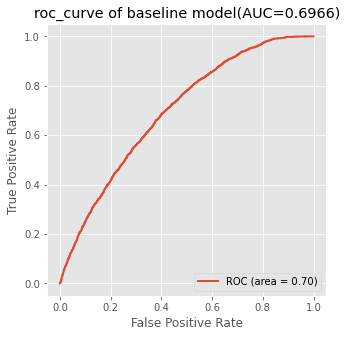

In [17]:
gbm_fpr,gbm_tpr,gbm_threasholds=roc_curve(test.iloc[:,1],test.iloc[:,2]) # 计算ROC的值,svm_threasholds为阈值

roc_auc = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(5, 5))
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.title("roc_curve of %s(AUC=%.4f)" %('baseline model',roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr,gbm_tpr, label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.legend(loc="lower right")
plt.savefig("baseline_roc.png")

In [18]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()

df_importance_top20 = df_importance.sort_values(by="importance", ascending=False).iloc[0:20,:]
df_importance_top100 = df_importance.sort_values(by="importance", ascending=False).iloc[0:100,:]
# print(df_importance_top100.iloc[:,0].tolist())

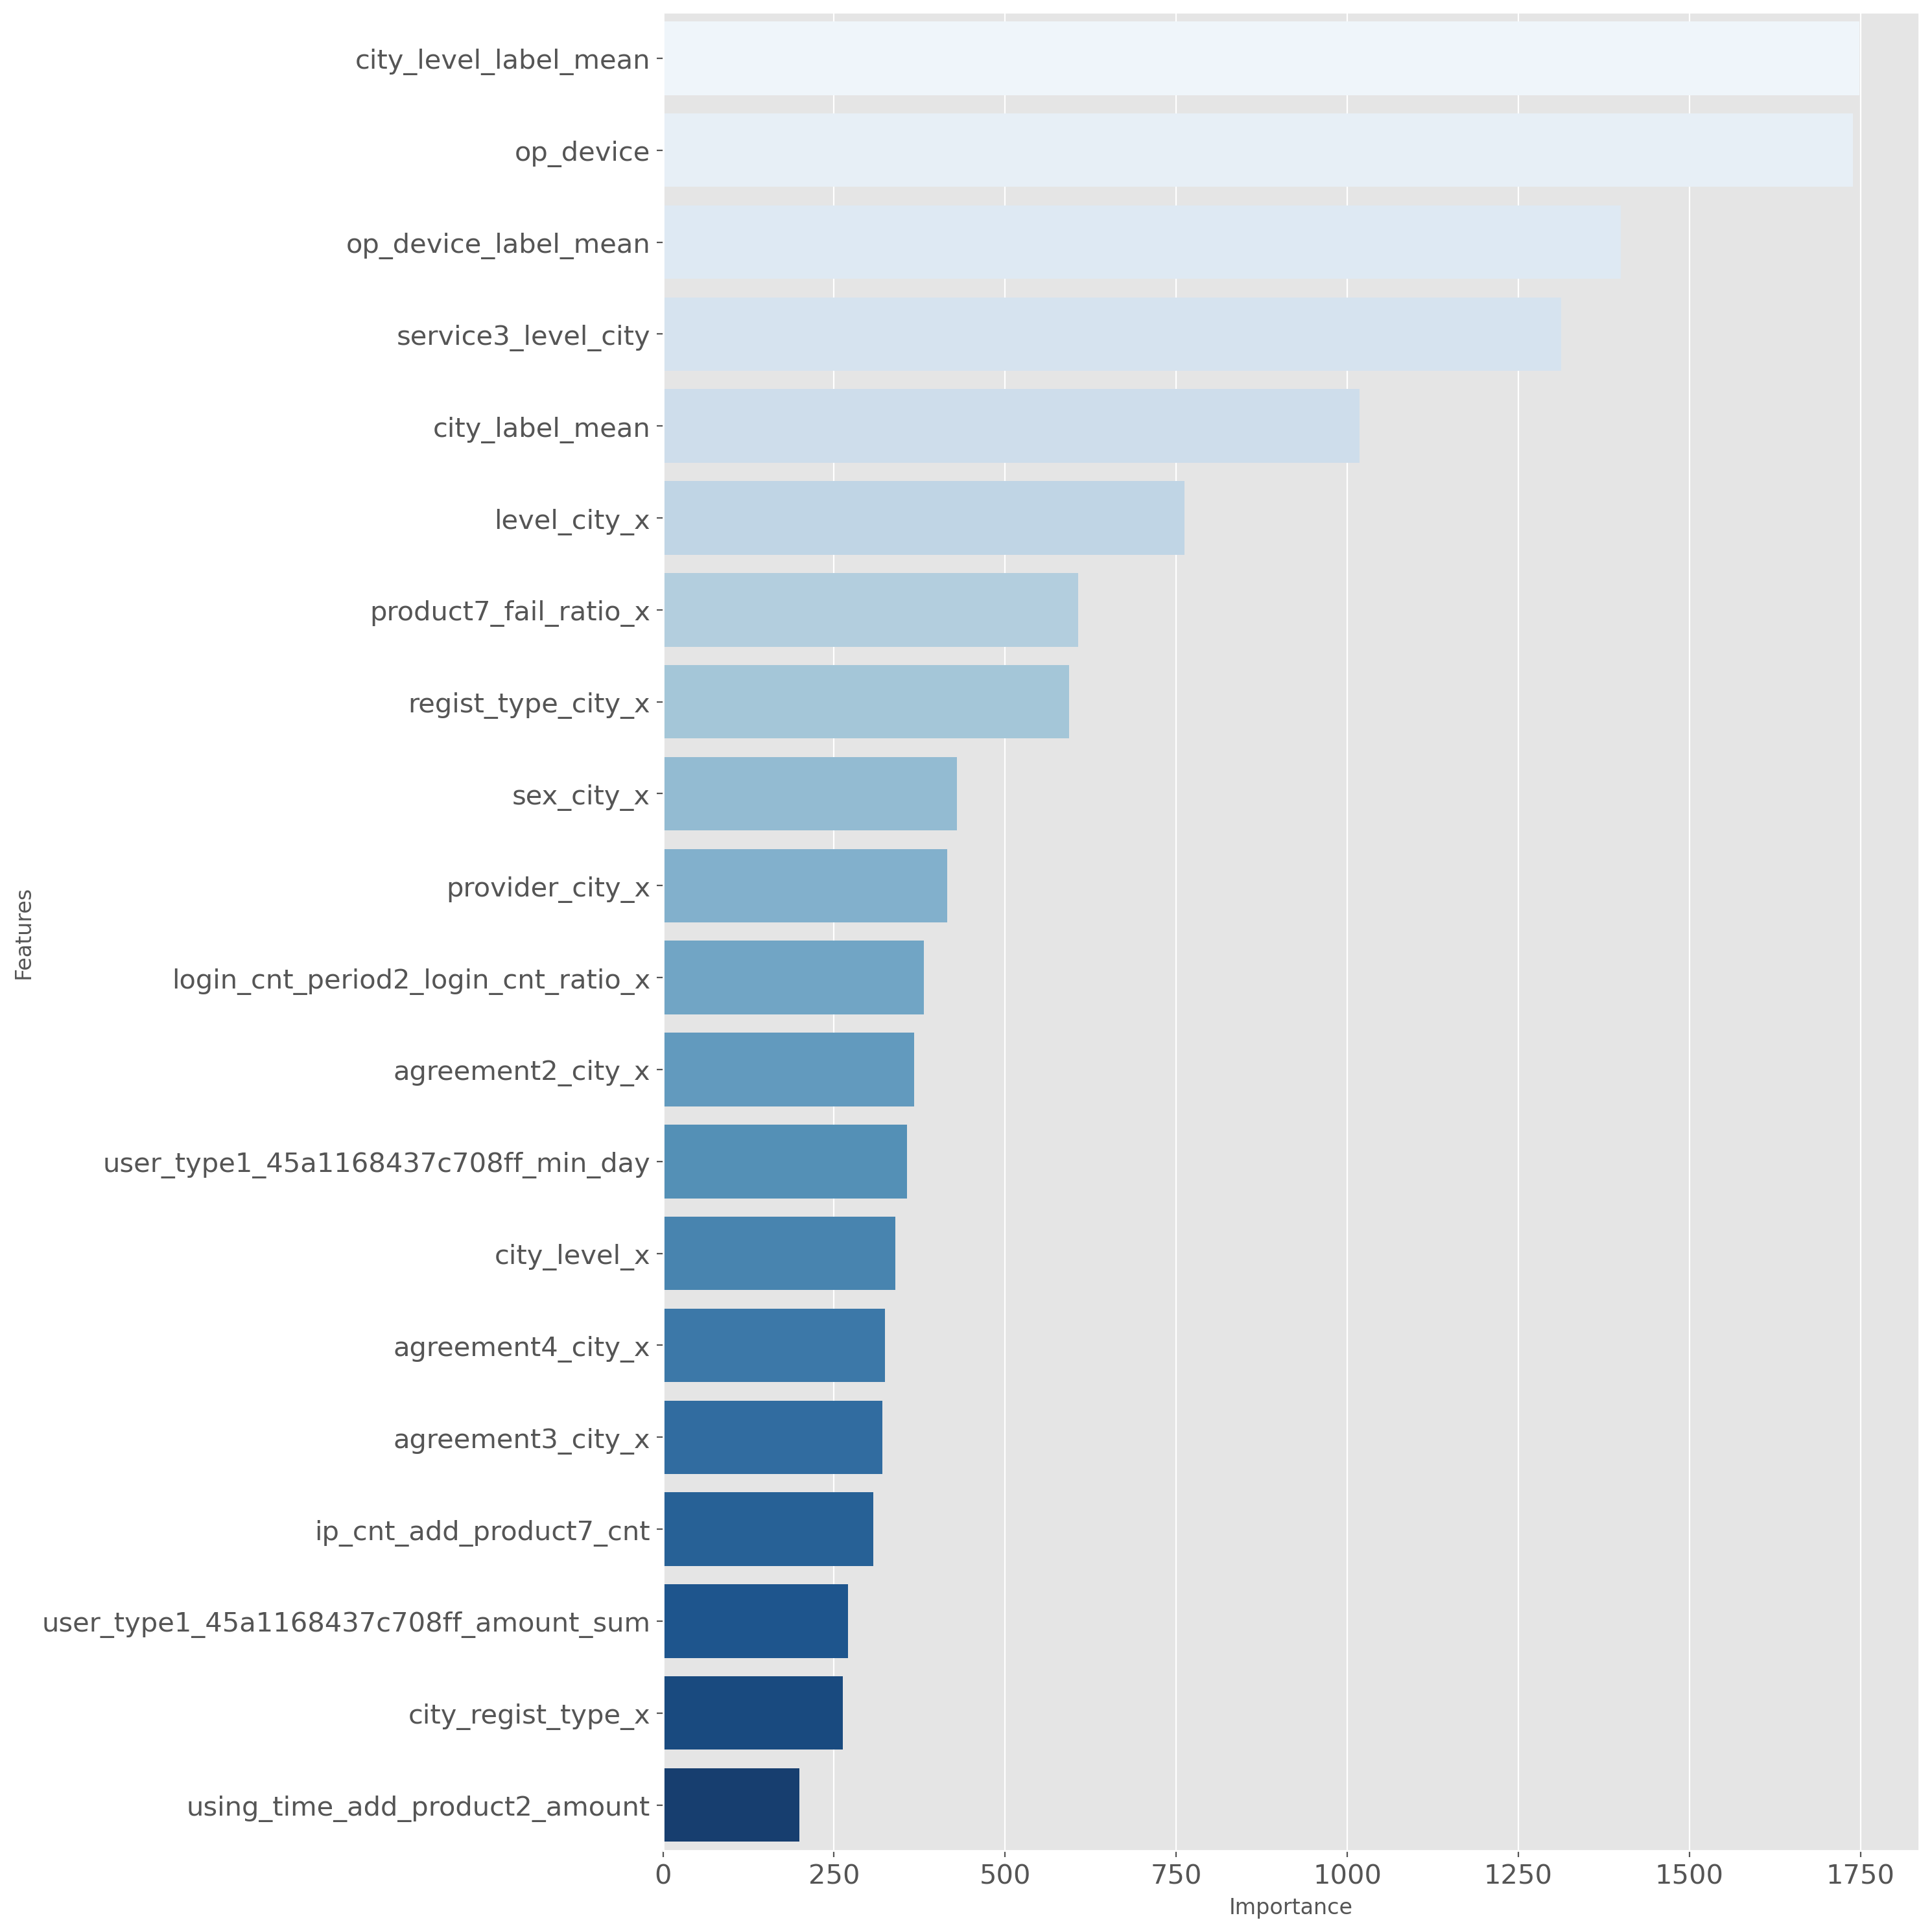

In [19]:
# feature importance visualization

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="importance", y="column", data=df_importance_top20, palette='Blues' ) 
# plt.title('LightGBM Features (avg over folds)')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.xlabel('Importance')
plt.ylabel('Features')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.show()
plt.savefig('lgbm_importances.png')

# XGBoost

In [20]:
%%time
ycol = 'label'
feature_names = list(
    filter(lambda x: x not in [ycol, 'user'], df_train.columns))

model = xgb.XGBClassifier( 
                           max_depth=6,
                           learning_rate=0.01,
                           n_estimators=10000,
                           subsample=0.8,
                           reg_alpha=10,
                           reg_lambda=12,
#                             tree_method='gpu_hist',
                           random_state=seed)

df_oof = df_train[['user', ycol]].copy()
df_oof['prob'] = 0
prediction = df_test[['user']]
prediction['prob'] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for fold_id, (trn_idx, val_idx) in enumerate(
        kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(
        fold_id + 1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          eval_metric='auc', 
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(X_val,)[:, 1]
    df_oof.loc[val_idx, 'prob'] = pred_val

    pred_test = lgb_model.predict_proba(df_test[feature_names])[:, 1]
    prediction['prob'] += pred_test / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()

<timed exec>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_1 Training ================================



C:\Users\EricChan98\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[0]	validation_0-auc:0.70574	validation_1-auc:0.68421
[100]	validation_0-auc:0.78734	validation_1-auc:0.75649
[200]	validation_0-auc:0.81065	validation_1-auc:0.77023
[300]	validation_0-auc:0.82762	validation_1-auc:0.78044
[400]	validation_0-auc:0.84196	validation_1-auc:0.78821
[500]	validation_0-auc:0.85276	validation_1-auc:0.79459
[600]	validation_0-auc:0.86244	validation_1-auc:0.79950
[700]	validation_0-auc:0.87167	validation_1-auc:0.80333
[800]	validation_0-auc:0.88015	validation_1-auc:0.80635
[900]	validation_0-auc:0.88735	validation_1-auc:0.80839
[1000]	validation_0-auc:0.89418	validation_1-auc:0.81032
[1100]	validation_0-auc:0.90039	validation_1-auc:0.81161
[1200]	validation_0-auc:0.90648	validation_1-auc:0.81290
[1300]	validation_0-auc:0.91219	validation_1-auc:0.81397
[1400]	validation_0-auc:0.91807	validation_1-auc:0.81483
[1500]	validation_0-auc:0.92323	validation_1-auc:0.81550
[1600]	validation_0-auc:0.92812	validation_1-auc:0.81571
[1700]	validation_0-auc:0.93278	validation_

<timed exec>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_2 Training ================================

[0]	validation_0-auc:0.70764	validation_1-auc:0.68225
[100]	validation_0-auc:0.78764	validation_1-auc:0.74179
[200]	validation_0-auc:0.81101	validation_1-auc:0.75792
[300]	validation_0-auc:0.82776	validation_1-auc:0.76994
[400]	validation_0-auc:0.84147	validation_1-auc:0.77924
[500]	validation_0-auc:0.85283	validation_1-auc:0.78669
[600]	validation_0-auc:0.86294	validation_1-auc:0.79230
[700]	validation_0-auc:0.87210	validation_1-auc:0.79635
[800]	validation_0-auc:0.87959	validation_1-auc:0.79963
[900]	validation_0-auc:0.88728	validation_1-auc:0.80253
[1000]	validation_0-auc:0.89369	validation_1-auc:0.80438
[1100]	validation_0-auc:0.90008	validation_1-auc:0.80592
[1200]	validation_0-auc:0.90601	validation_1-auc:0.80718
[1300]	validation_0-auc:0.91212	validation_1-auc:0.80793
[1400]	validation_0-auc:0.91729	validation_1-auc:0.80861
[1500]	validation_0-auc:0.92246	validation_1-auc:0.80906
[1600]	validation_0-auc:0.92719	validation_1-auc:

In [21]:
pred_xgb = prediction

In [22]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby([
    'column'
])['importance'].agg('mean').sort_values(ascending=False).reset_index()
df_importance

,column,importance
0,user_amount_cnt,0.055119
1,count_amount_trans_max,0.026472
2,agreement3_city_x,0.019369
3,regist_type_city_x,0.010195
4,user_trans_type1_nuniq,0.009559
...,...,...
740,level_province_y,0.000000
741,level_provider_y,0.000000
742,level_provider_x,0.000000
743,level_level_y,0.000000


In [23]:
auc = roc_auc_score(df_oof[ycol], df_oof['prob'])
print('auc:', auc)

auc: 0.8134700120016511


In [24]:
del auc

In [25]:
test_y = pd.read_csv('test_label_new.csv', index_col=0)
test = pd.merge(test_y,prediction, on='user')

In [26]:
test.head()

,user,label,prob
0,Train_08043,1,0.156887
1,Train_28969,0,0.004566
2,Train_09002,1,0.265456
3,Train_05608,1,0.309702
4,Train_25993,0,0.366341


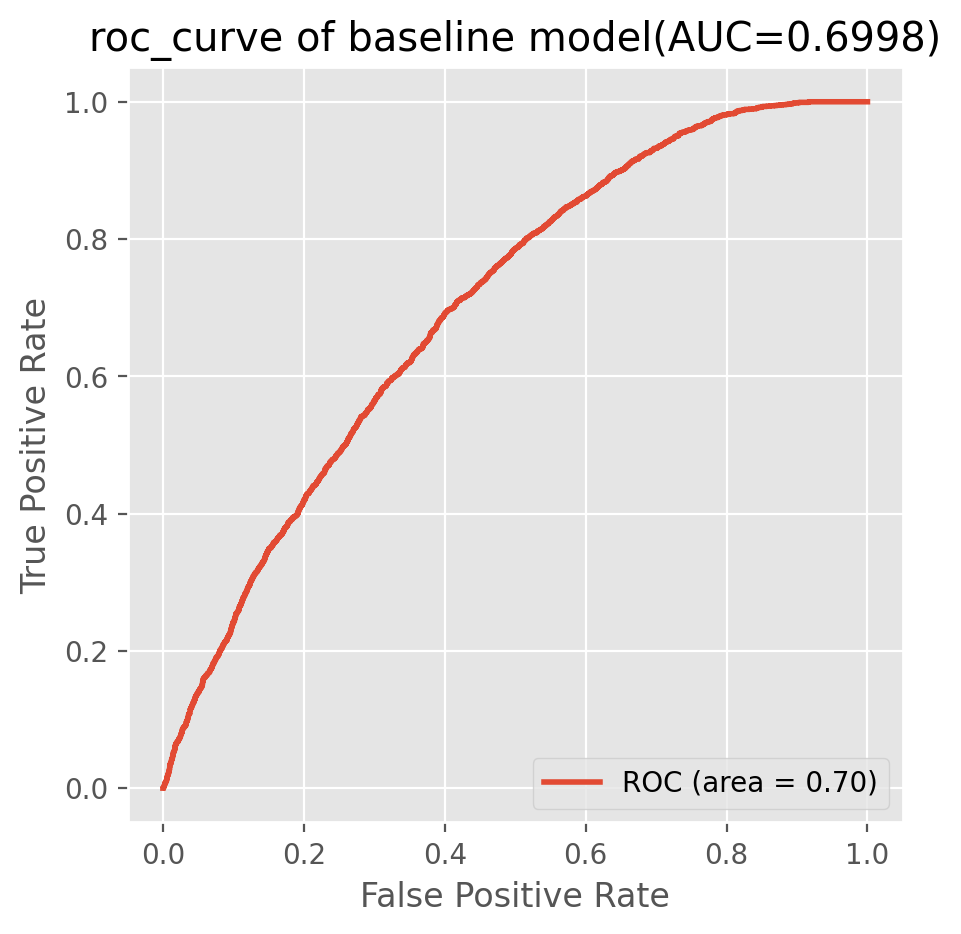

In [28]:
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score, roc_curve, auc
gbm_fpr,gbm_tpr,gbm_threasholds=roc_curve(test.iloc[:,1],test.iloc[:,2]) # 计算ROC的值,svm_threasholds为阈值

roc_auc = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(5, 5))
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.title("roc_curve of %s(AUC=%.4f)" %('baseline model',roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr,gbm_tpr, label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.legend(loc="lower right")
plt.savefig("baseline_roc.png")

In [29]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()

df_importance_top20 = df_importance.sort_values(by="importance", ascending=False).iloc[0:20,:]
df_importance_top100 = df_importance.sort_values(by="importance", ascending=False).iloc[0:100,:]
# print(df_importance_top100.iloc[:,0].tolist())

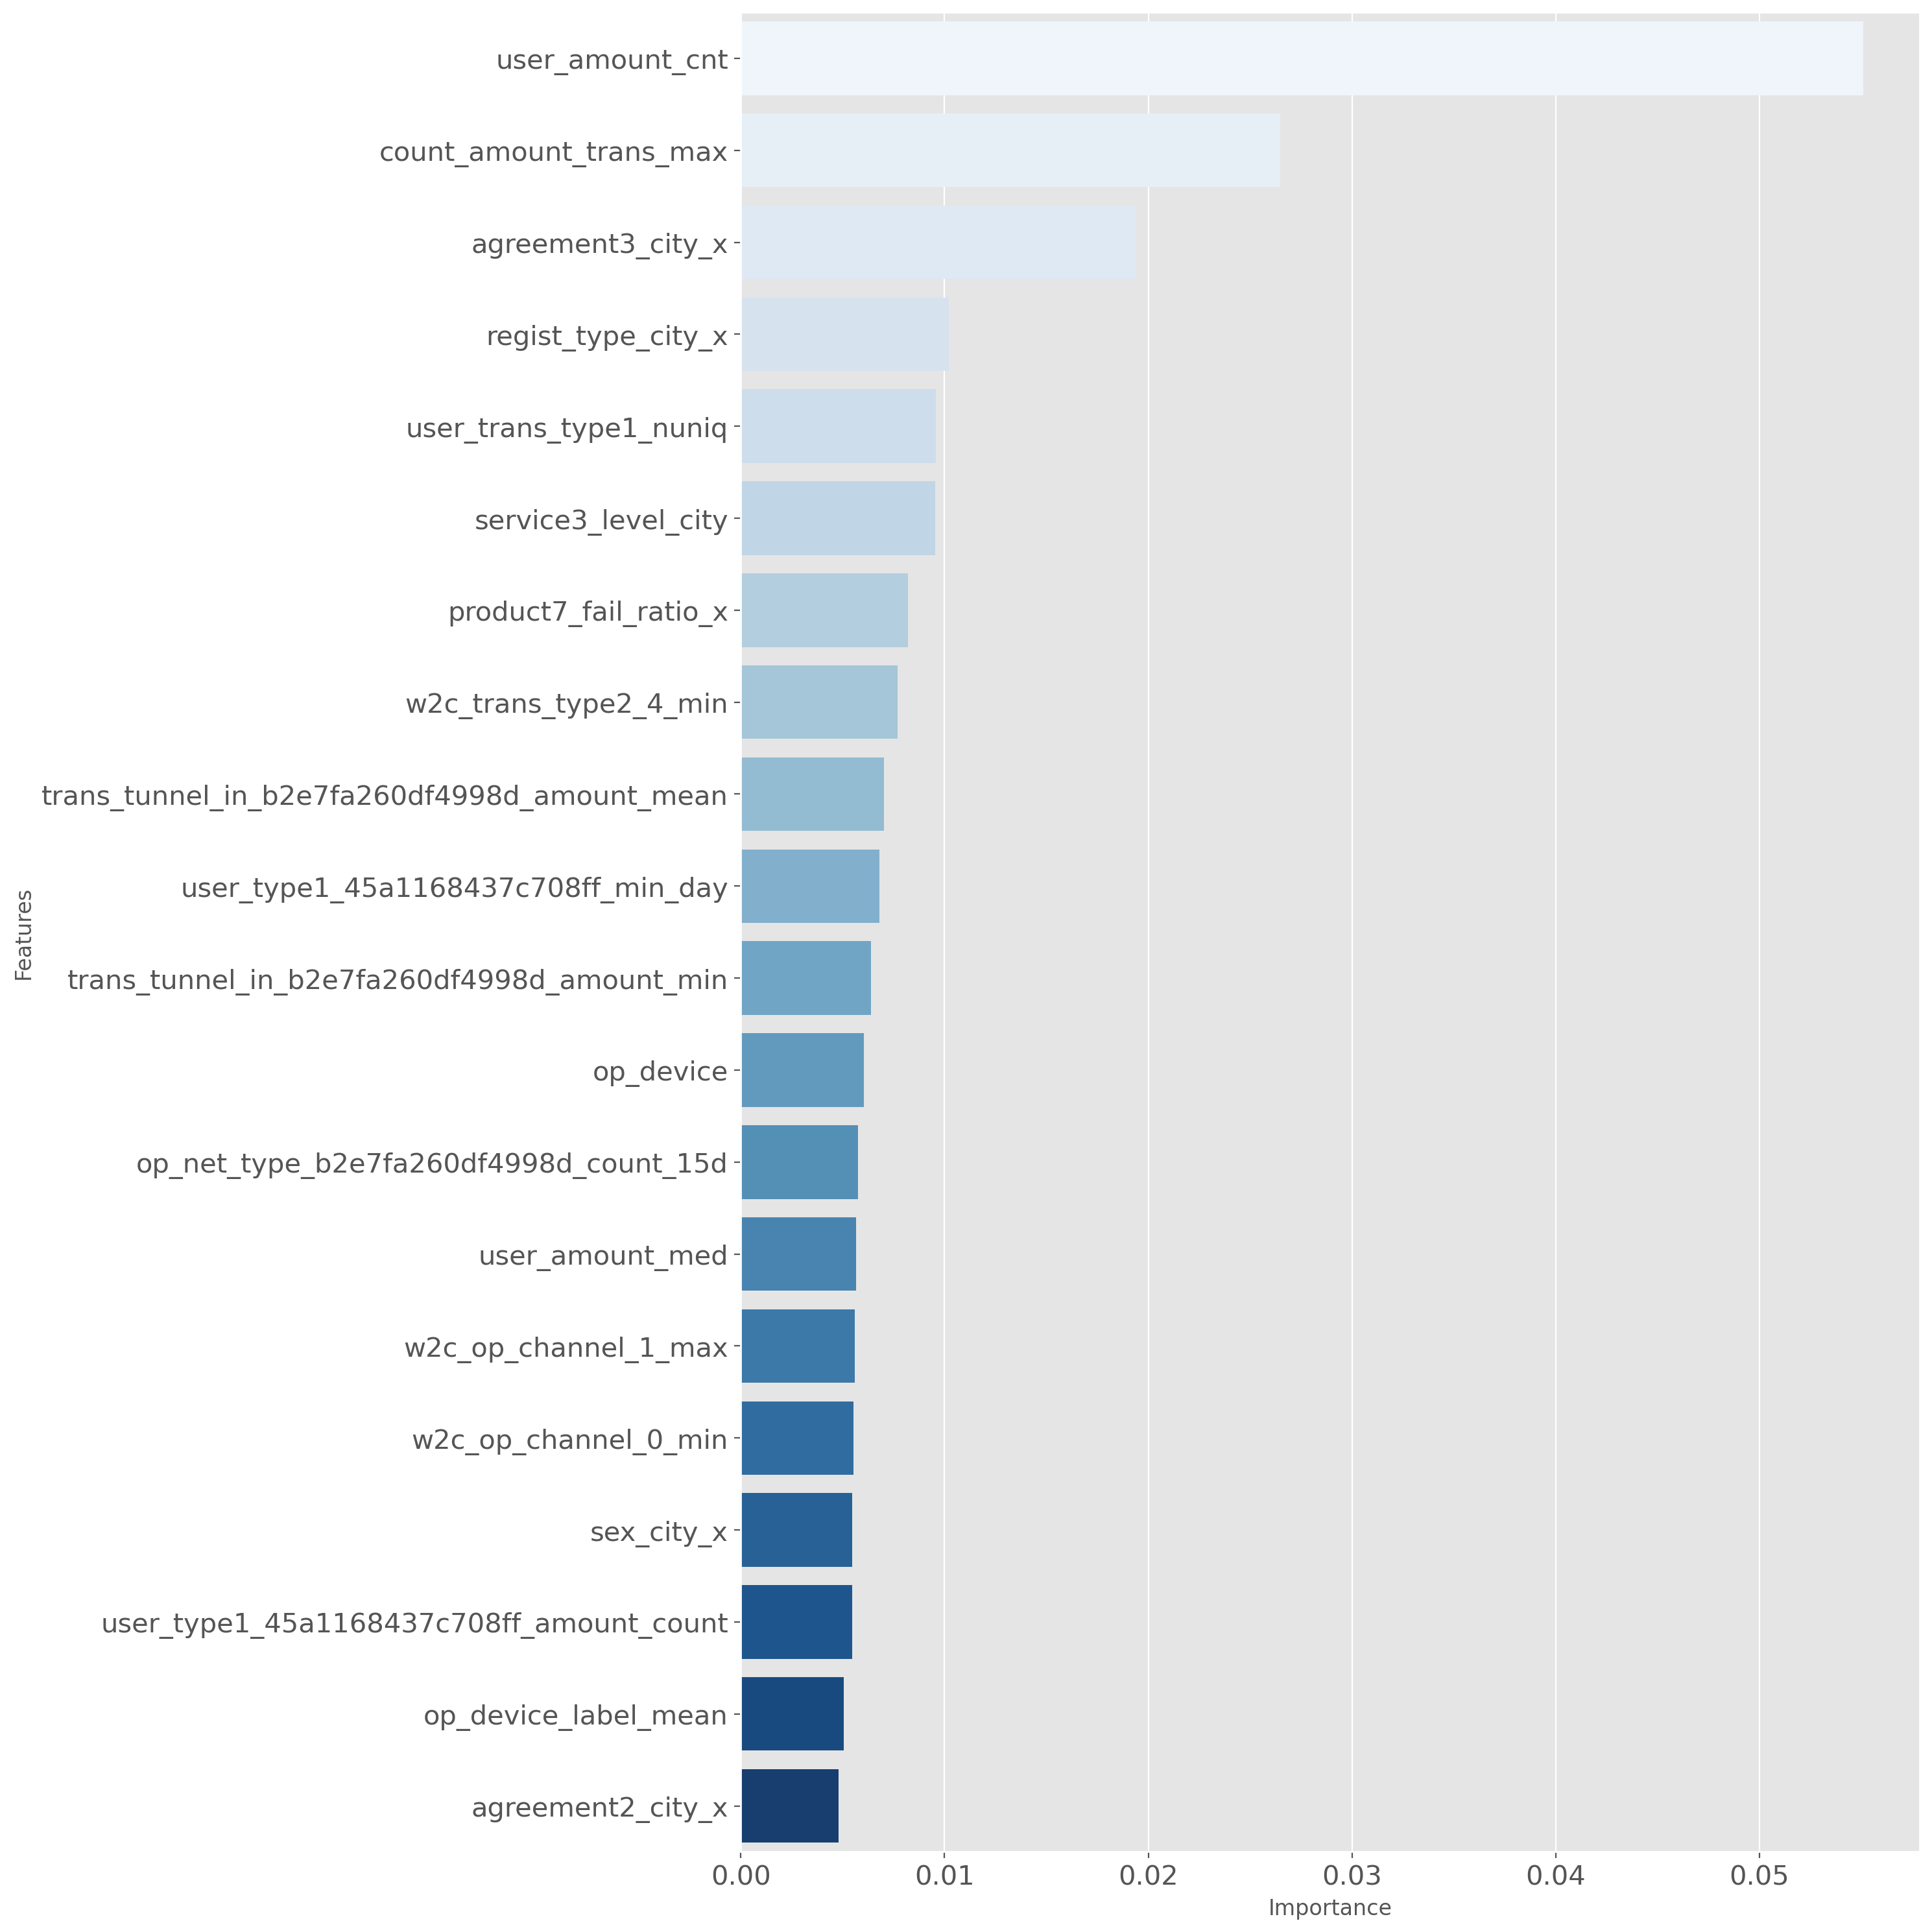

In [30]:
# feature importance visualization

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="importance", y="column", data=df_importance_top20, palette='Blues' ) 
# plt.title('LightGBM Features (avg over folds)')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.xlabel('Importance')
plt.ylabel('Features')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.show()
plt.savefig('xgb_importances.png')